# Monkey Classification: End-to-end Pipeline
In this notebook we're going to show how you can train and serve a simple model using Kubeflow pipelines!<br>

The dataset we're using consists of two folders; training and validation. Each folder contains 10 subforders labeled as n0~n9, each corresponding a species from Wikipedia's monkey cladogram. Images are 400x300 px or larger and JPEG format.

You'll need:
- Just this notebook
- Kubeflow deployed on either OpenShift or Kubernetes (make sure it is on IBM Power, we don't support x86!)
- Internet connection to download the sample images (you can also manually upload them to your preferred S3 bucket - e.g. minio)

Datasource: https://www.kaggle.com/slothkong/10-monkey-species

## Authors
- Marvin Giessing <MARVING@de.ibm.com>
- Sebastian Lehrig <sebastian.lehrig1@ibm.com>

## References
- https://www.philschmid.de/image-classification-huggingface-transformers-keras
- https://discuss.huggingface.co/t/solved-image-dataset-seems-slow-for-larger-image-size/10960/6

## License
Apache-2.0 License

## 0.) Imports & Constants

In [21]:
import cv2
import json
import kfp
from typing import NamedTuple
from kfp.components import (
    InputPath,
    OutputPath
)
import kfp.dsl as dsl
from kfp.dsl import (
    PipelineConf,
    data_passing_methods
)
from kubernetes.client.models import (
    V1Volume,
    V1PersistentVolumeClaimVolumeSource
)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import requests

In [41]:
# Environment-specific configurations
#
# %env MINIO_URL minio-service-kubeflow.apps.b2s001.pbm.ihost.com
# %env REMOTE_HOST https://129.40.19.51:6443
# %env REMOTE_HOST https://129.40.19.55:6443
# %env REMOTE_NAMESPACE default
# %env TRAINING_GPUS 1
# %env TRAINING_NODE_SELECTOR nvidia.com/gpu.product: "Tesla-V100-SXM2-32GB"
#
# Reset:
# del os.environ['MINIO_URL']
# del os.environ['REMOTE_HOST']
# del os.environ['REMOTE_NAMESPACE']
# del os.environ['TRAINING_GPUS']
# del os.environ['TRAINING_NODE_SELECTOR']

In [42]:
COMPONENT_CATALOG_FOLDER = f"{os.getenv('HOME')}/components"
COMPONENT_CATALOG_GIT = "https://github.com/lehrig/kubeflow-ppc64le-components.git"
COMPONENT_CATALOG_RELEASE = "main"

LOAD_DATASET_COMPONENT = f"{COMPONENT_CATALOG_FOLDER}/data-collection/load-dataset/component.yaml"
TRAIN_MODEL_COMPONENT = f"{COMPONENT_CATALOG_FOLDER}/model-building/train-model-job/component.yaml"
PLOT_CONFUSION_MATRIX_COMPONENT = f"{COMPONENT_CATALOG_FOLDER}/model-building/plot-confusion-matrix/component.yaml"
CONVERT_MODEL_TO_ONNX_COMPONENT = f"{COMPONENT_CATALOG_FOLDER}/model-building/convert-to-onnx/component.yaml"
UPLOAD_MODEL_COMPONENT = f"{COMPONENT_CATALOG_FOLDER}/model-building/upload-model/component.yaml"
DEPLOY_MODEL_WITH_KSERVE_COMPONENT = f"{COMPONENT_CATALOG_FOLDER}/model-deployment/deploy-model-with-kserve/component.yaml"

BASE_IMAGE = "quay.io/ibm/kubeflow-notebook-image-ppc64le:latest"

ARGUMENTS = {
    'blackboard': 'artefacts',
    'dataset_url': 'Lehrig/Monkey-Species-Collection',
    'dataset_configuration': 'downsized',
    'dataset_label_column': 'label',
    'model_name': "monkey-classification",
    'minio_url': os.getenv('MINIO_URL', default='minio-service.kubeflow:9000'),
    'training_gpus': os.getenv('TRAINING_GPUS', default='1'),
    'training_node_selector': os.getenv('TRAINING_NODE_SELECTOR', default=''),
    'remote_host': os.getenv('REMOTE_HOST', default=''),
    'remote_namespace': os.getenv('REMOTE_NAMESPACE', default=''),
}
MODEL_NAME = ARGUMENTS["model_name"]

with open("/var/run/secrets/kubernetes.io/serviceaccount/namespace") as f:
    NAMESPACE = f.read()

ARGUMENTS

{'blackboard': 'artefacts',
 'dataset_url': 'Lehrig/Monkey-Species-Collection',
 'dataset_configuration': 'downsized',
 'dataset_label_column': 'label',
 'model_name': 'monkey-classification',
 'minio_url': 'minio-service-kubeflow.apps.b2s001.pbm.ihost.com',
 'training_gpus': '1',
 'training_node_selector': '',
 'remote_host': 'https://129.40.19.55:6443',
 'remote_namespace': 'default'}

## 1.) Let's start with creating a client object for interaction

In [43]:
client = kfp.Client()

## 2.) The main part consists of defining the end-to-end workflow functions and create components from them
### 2.0) Load component catalog

In [44]:
!git clone --branch $COMPONENT_CATALOG_RELEASE $COMPONENT_CATALOG_GIT $COMPONENT_CATALOG_FOLDER

fatal: destination path '/home/jovyan/components' already exists and is not an empty directory.


### 2.1) Load dataset (by reusing a Kubeflow component)

In [45]:
load_dataset_comp = kfp.components.load_component_from_file(
    LOAD_DATASET_COMPONENT
)

### 2.2) Preprocess data (normalizing, one hot encoding, etc.)

In [46]:
def preprocess_dataset(
    dataset_dir: InputPath(str),
    prep_dataset_dir: OutputPath(str),
    test_size: float = 0.2,
    seed: int = 42,
    size: int = 224,
    batch_size: int = 16
):
    """Split data into train/dev/test data. Saves result into `prep_dataset_dir`."""

    from datasets import (
        Array3D,
        DatasetDict,
        Features,
        load_from_disk,
        Sequence,
        Value
    )
    import numpy as np
    import os
    from transformers import ImageFeatureExtractionMixin

    print(f'Loading input dataset from {dataset_dir}...')
    dataset = load_from_disk(dataset_dir)
    print('Dataset loaded.')

    # Preprocess
    num_classes = dataset["train"].features["label"].num_classes
    one_hot_matrix = np.eye(num_classes)
    feature_extractor = ImageFeatureExtractionMixin()

    def to_pixels(image):
        image = feature_extractor.resize(image, size=size)
        image = feature_extractor.to_numpy_array(image, channel_first=False)
        image = image / 255.0
        return image

    def process(examples):
        examples["pixel_values"] = [
            to_pixels(image) for image in examples["image"]
        ]
        examples["label"] = [
            one_hot_matrix[label] for label in examples["label"]
        ]
        return examples

    features = Features({
        "pixel_values": Array3D(dtype="float32", shape=(size, size, 3)),
        "label": Sequence(feature=Value(dtype="int32"), length=num_classes)
    })

    print('Preprocessing dataset...')
    prep_dataset = dataset.map(
        process,
        remove_columns=["image"],
        batched=True,
        batch_size=batch_size,
        num_proc=2,
        features=features,
        keep_in_memory=True
    )

    prep_dataset = prep_dataset.with_format("numpy")

    # Split
    print('Splitting dataset...')
    dev_test_dataset = prep_dataset['test'].train_test_split(
        test_size=test_size,
        shuffle=True,
        seed=seed
    )

    train_dev_test_dataset = DatasetDict({
        'train': prep_dataset['train'],
        'dev': dev_test_dataset['train'],
        'test': dev_test_dataset['test'],
    })

    print(f'Storing dataset to {prep_dataset_dir}...')
    if not os.path.exists(prep_dataset_dir):
        os.makedirs(prep_dataset_dir)
    train_dev_test_dataset.save_to_disk(prep_dataset_dir)
    print(f'Dataset with train/test/dev splits saved to {prep_dataset_dir}.')

    print('Finished.')


preprocess_dataset_comp = kfp.components.create_component_from_func(
    func=preprocess_dataset,
    base_image=BASE_IMAGE
)

### 2.3) Train the model

In [47]:
def train_model(
    prep_dataset_dir: InputPath(str),
    model_dir: OutputPath(str),
    epochs: int = 100,
    batch_size: int = 32
):
    """Uses transfer learning on a prepared dataset. Once trained, the model is persisted to `model_dir`."""

    from datasets import load_from_disk
    import datetime
    import numpy as np
    import os
    import tensorflow as tf
    from tensorflow.keras import Sequential
    from tensorflow.keras.applications import InceptionV3
    from tensorflow.keras.layers import (
        BatchNormalization,
        Dense,
        Dropout,
        GlobalAveragePooling2D
    )
    from tensorflow.keras.callbacks import (
        EarlyStopping,
        ModelCheckpoint,
        ReduceLROnPlateau
    )
    from transformers import DefaultDataCollator

    dataset = load_from_disk(prep_dataset_dir)

    data_collator = DefaultDataCollator(return_tensors="tf")

    train_dataset = dataset["train"].to_tf_dataset(
        columns=['pixel_values'],
        label_cols=['labels'],
        shuffle=True,
        batch_size=batch_size,
        collate_fn=data_collator
    )

    validation_dataset = dataset["dev"].to_tf_dataset(
        columns=['pixel_values'],
        label_cols=['labels'],
        shuffle=False,
        batch_size=batch_size,
        collate_fn=data_collator
    )

    # see: https://github.com/huggingface/datasets/issues/4478
    print(f'{datetime.datetime.now()} - Saving Data')
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        os.makedirs(model_dir+"/train")
        os.makedirs(model_dir+"/val")
    tf.data.experimental.save(train_dataset, model_dir+"/train")
    tf.data.experimental.save(validation_dataset, model_dir+"/val")

    print(f'{datetime.datetime.now()} - Loading Data')
    train_dataset = tf.data.experimental.load(model_dir+"/train")
    validation_dataset = tf.data.experimental.load(model_dir+"/val")

    shape = np.shape(dataset["train"][0]["pixel_values"])
    backbone = InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=shape
    )

    for layer in backbone.layers:
        layer.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())

    earlyStopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=0,
        mode='min'
    )

    mcp_save = ModelCheckpoint(
        f'{model_dir}/best_model.hdf5',
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )

    reduce_lr_loss = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=7,
        verbose=1,
        min_delta=0.0001,
        mode='min'
    )

    hist = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=validation_dataset,
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
    )

    print("Model train history:")
    print(hist.history)

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model.save(model_dir)
    print(f"Model saved to: {model_dir}")
    print('Finished.')


train_specification = kfp.components.func_to_component_text(
    func=train_model
)

In [48]:
train_model_comp = kfp.components.load_component_from_file(
    TRAIN_MODEL_COMPONENT
)

### 2.4) Evaluate model with validation data

In [57]:
def evaluate_model(
    prep_dataset_dir: InputPath(str),
    model_dir: InputPath(str),
    batch_size: int = 20
) -> NamedTuple(
        "EvaluationOutput", [
            ("mlpipeline_metrics", "Metrics")
        ]):
    """Loads a saved model from file and uses a pre-downloaded dataset for evaluation.
    Model metrics are persisted to `/mlpipeline-metrics.json` for Kubeflow Pipelines
    metadata."""

    from collections import namedtuple
    from datasets import load_from_disk
    import json
    import tensorflow as tf
    from transformers import DefaultDataCollator

    dataset = load_from_disk(prep_dataset_dir)

    data_collator = DefaultDataCollator(return_tensors="tf")

    test_dataset = dataset["test"].to_tf_dataset(
        columns=['pixel_values'],
        label_cols=['labels'],
        shuffle=False,
        batch_size=batch_size,
        collate_fn=data_collator
    )

    # see: https://github.com/huggingface/datasets/issues/4478
    tf.data.experimental.save(test_dataset, "./test")
    test_dataset = tf.data.experimental.load("./test")

    model = tf.keras.models.load_model(model_dir)
    (loss, accuracy) = model.evaluate(test_dataset)

    print((loss, accuracy))

    metrics = {
        "metrics": [
            {
                "name": "loss",
                "numberValue": str(loss),
                "format": "PERCENTAGE"
            },
            {
                "name": "accuracy",
                "numberValue": str(accuracy),
                "format": "PERCENTAGE"},
        ]
    }

    out_tuple = namedtuple("EvaluationOutput", ["mlpipeline_metrics"])

    return out_tuple(json.dumps(metrics))


evaluate_model_comp = kfp.components.create_component_from_func(
    func=evaluate_model,
    base_image=BASE_IMAGE
)

### 2.5) Create confusion matrix (by reusing a Kubeflow component)

In [58]:
plot_confusion_matrix_comp = kfp.components.load_component_from_file(
    PLOT_CONFUSION_MATRIX_COMPONENT
)

### 2.6) Convert model to ONNX (by reusing a Kubeflow component)

In [59]:
convert_model_to_onnx_comp = kfp.components.load_component_from_file(
    CONVERT_MODEL_TO_ONNX_COMPONENT
)

### 2.7) Upload model to MinIO artifact store (by reusing a Kubeflow component)

In [60]:
upload_model_comp = kfp.components.load_component_from_file(
    UPLOAD_MODEL_COMPONENT
)

### 2.8) Deploy the model using KServe (by reusing a Kubeflow component)

In [61]:
deploy_model_with_kserve_comp = kfp.components.load_component_from_file(
    DEPLOY_MODEL_WITH_KSERVE_COMPONENT
)

## 3.) Create the actual pipeline by combining the components

In [62]:
@dsl.pipeline(
  name='End-to-end monkey species classification pipeline',
  description='An example pipeline that performs an image classification and determines different monkey species'
)
def monkey_pipeline(
            blackboard: str,
            dataset_url: str,
            dataset_configuration: str,
            dataset_label_column: str,
            model_name: str,
            minio_url: str,
            training_gpus: int,
            training_node_selector: str,
            remote_host: str,
            remote_namespace: str):
    create_blackboard = dsl.VolumeOp(
        name='Create Artefacts Blackboard',
        resource_name=blackboard,
        modes=dsl.VOLUME_MODE_RWO,
        size="4Gi",
        set_owner_reference=True
    )

    load_dataset_task = load_dataset_comp(
        path=dataset_url,
        configuration=dataset_configuration,
        label_column=dataset_label_column
    )
    load_dataset_task.after(create_blackboard)

    preprocess_dataset_task = preprocess_dataset_comp(
        dataset_dir=load_dataset_task.outputs['dataset_dir']
    )

    # InputPath and OutputPath like "prep_dataset_dir" & "model_dir":
    # Use name of parameters of train component on right-hand side.
    train_parameters = {
        "prep_dataset_dir": "dataset_directory",
        "model_dir": "model_dir",
    }

    train_model_task = train_model_comp(
        preprocess_dataset_task.outputs['prep_dataset_dir'],
        train_specification,
        train_parameters,
        model_name=model_name,
        gpus=training_gpus,
        node_selector=training_node_selector,
        remote_host=remote_host,
        namespace=remote_namespace,
        minio_url=minio_url,
    )

    evaluate_model_comp(
        preprocess_dataset_task.outputs['prep_dataset_dir'],
        train_model_task.outputs['model_dir']
    )

    plot_confusion_matrix_comp(
        "pixel_values",
        "labels",
        preprocess_dataset_task.outputs['prep_dataset_dir'],
        train_model_task.outputs['model_dir'],
        load_dataset_task.outputs['labels']
    )

    convert_model_to_onnx_task = convert_model_to_onnx_comp(
        train_model_task.outputs['model_dir']
    )

    upload_model_task = upload_model_comp(
        convert_model_to_onnx_task.outputs['onnx_model_dir'],
        minio_url,
        model_name=model_name
    )

    deploy_model_with_kserve_task = deploy_model_with_kserve_comp(
        model_name=model_name
    )

    deploy_model_with_kserve_task.after(upload_model_task)

## 4.) Run the pipeline within an experiment
Create a pipeline run, using the client you initialized in a prior step.

In [63]:
# See: https://www.kubeflow.org/docs/components/pipelines/overview/caching/#managing-caching-staleness
def disable_cache_transformer(op):
    if isinstance(op, dsl.ContainerOp):
        op.execution_options.caching_strategy.max_cache_staleness = "P0D"
    else:
        op.add_pod_annotation(name="pipelines.kubeflow.org/max_cache_staleness", value="P0D")
    return op


pipeline_conf = PipelineConf()
pipeline_conf.add_op_transformer(disable_cache_transformer)
pipeline_conf.data_passing_method = data_passing_methods.KubernetesVolume(
    volume=V1Volume(
        name=ARGUMENTS["blackboard"],
        persistent_volume_claim=V1PersistentVolumeClaimVolumeSource(
            "{{workflow.name}}-%s" % ARGUMENTS["blackboard"]
        ),
    ),
    path_prefix=f'{ARGUMENTS["blackboard"]}/',
)

client.create_run_from_pipeline_func(
    monkey_pipeline,
    arguments=ARGUMENTS,
    namespace=NAMESPACE,
    pipeline_conf=pipeline_conf
)

RunPipelineResult(run_id=3c749940-7ed3-48cd-adc1-44be7d9cf7fe)

## 5.) Test model deployment
See API documentation: https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md

### 5.1) Check model endpoint availability

In [64]:
HOST = f'{MODEL_NAME}-predictor-default.{NAMESPACE}'
HEADERS = {'Host': HOST}
MODEL_ENDPOINT = f'http://{MODEL_NAME}-predictor-default/v2/models/{MODEL_NAME}'

res = requests.get(MODEL_ENDPOINT, headers=HEADERS)
response = json.loads(res.text)
response

{'name': 'monkey-classification',
 'versions': ['1'],
 'platform': 'onnxruntime_onnx',
 'inputs': [{'name': 'inception_v3_input',
   'datatype': 'FP32',
   'shape': [-1, 224, 224, 3]}],
 'outputs': [{'name': 'dense_2', 'datatype': 'FP32', 'shape': [-1, 10]}]}

Note you can also do this:
```curl -H "Host: $HOST" $MODEL_ENDPOINT```

### 5.2) Get test image

In [30]:
IMAGE = "Monkey.jpg"
#IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/0/00/Uakari_male.jpg" #Uakari
IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/Panamanian_Male_Adult_Howler_Monkey.jpg/2560px-Panamanian_Male_Adult_Howler_Monkey.jpg" # Howler
#IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/c/c6/Patas_Monkey.jpg" # Patas
MONKEYS = np.array(["Mantled howler (Alouatta palliata)",
                    "Patas monkey (Erythrocebus patas)",
                    "Bald uakari (Cacajao calvus)",
                    "Japanese macaque (Macaca fuscata)",
                    "Pygmy marmoset (Cebuella pygmaea)",
                    "Colombian white-faced capuchin (Cebus capucinus)",
                    "Silvery marmoset (Mico argentatus)",
                    "Common squirrel monkey (Saimiri sciureus)",
                    "Black headed night monkey (Aotus nigriceps)",
                    "Nilgiri langur (Trachypithecus johnii)"]) # Note: last monkey after sorting

In [31]:
!wget $IMAGE_URL -O $IMAGE

--2022-06-09 20:55:40--  https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/Panamanian_Male_Adult_Howler_Monkey.jpg/2560px-Panamanian_Male_Adult_Howler_Monkey.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 923915 (902K) [image/jpeg]
Saving to: ‘Monkey.jpg’

Monkey.jpg          100%[===================>] 902.26K  4.95MB/s    in 0.2s    

2022-06-09 20:55:40 (4.95 MB/s) - ‘Monkey.jpg’ saved [923915/923915]



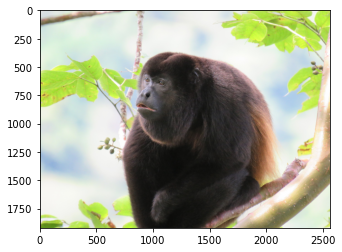

In [32]:
image = mpimg.imread(IMAGE)
image_plot = plt.imshow(image)

### 5.3) Predict monkey kind of test image

In [33]:
PREDICT_ENDPOINT = MODEL_ENDPOINT + "/infer"

test_image = cv2.resize(cv2.imread(IMAGE), dsize=(224, 224)) / 255.0

payload = {
  "inputs": [{
      "name": "inception_v3_input",
      "shape": [1, 224, 224, 3],
      "datatype": "FP32",
      "data": test_image.tolist()
    }
  ]
}

res = requests.post(PREDICT_ENDPOINT, headers=HEADERS, data=json.dumps(payload))
response = json.loads(res.text)
response

{'model_name': 'monkey-classification',
 'model_version': '1',
 'outputs': [{'name': 'dense_2',
   'datatype': 'FP32',
   'shape': [1, 10],
   'data': [0.9849440455436707,
    4.0273986087413505e-05,
    0.011197958141565323,
    0.0025272159837186337,
    5.832055467180908e-05,
    0.00015985753270797431,
    0.0005517776007764041,
    4.833210550714284e-05,
    3.758039019885473e-05,
    0.00043450677185319364]}]}

Note you can also do this:
```curl -s -X POST -H "Host: $HOST" -d @$JSON_FILE $PREDICT_ENDPOINT```

In [34]:
print("Looks like a " + MONKEYS[np.argmax(response['outputs'][0]['data'])])

Looks like a Mantled howler (Alouatta palliata)
